In [1]:
import csv
import math
import re
import pandas as pd
import requests
import numpy as np
import io

# Collecting the data

The Dataset cannot be pushed to Github. Github has decreased the allowed file size so the dataset will have to be downloaded manually.

The url is: https://data.cms.gov/provider-data/sites/default/files/resources/69a75aa9d3dc1aed6b881725cf0ddc12_1671768321/DAC_NationalDownloadableFile.csv

The Data Dictionary for this section of datasets: https://data.cms.gov/provider-data/sites/default/files/data_dictionaries/physician/DOC_Data_Dictionary.pdf

The webpage for this section of datasets: https://data.cms.gov/provider-data/topics/doctors-clinicians


In [2]:
df = pd.read_csv('/Users/johannahoang/Downloads/DAC_NationalDownloadableFile.csv', encoding='windows-1252', dtype='string')

(TODO) Filtering and Cleaning the Dataset

Note: Since this is for Physicians, we will need to filter out non-physicians, but keep in mind that some physicians will also have a secondary degree listed under their specialities, so the filtering needs to be a bit smarter

In [3]:
# NOTE: Optimize This
addresses = df[['adr_ln_1', 'cty', 'st', 'zip','pri_spec']]
addresses.drop_duplicates()
addresses.dropna()
addresses = addresses[addresses['adr_ln_1'].str.strip().astype(bool)]
addresses = addresses[addresses['cty'].str.strip().astype(bool)]
addresses = addresses[addresses['st'].str.strip().astype(bool)]
addresses = addresses[addresses['zip'].str.strip().astype(bool)]
addresses = addresses[addresses['pri_spec'].str.strip().astype(bool)]
addresses['pri_spec'] = addresses['pri_spec'].astype(str)
print(addresses.head())
print(addresses.shape[0])

             adr_ln_1             cty  st        zip                pri_spec
0     1582 N BROAD ST        TAZEWELL  TN  378794352      NURSE PRACTITIONER
1   5632 ANNAPOLIS RD     BLADENSBURG  MD  207102213      NURSE PRACTITIONER
2    611 E CARLSON ST        CHEYENNE  WY  820094335       INTERNAL MEDICINE
3         30 RIVER ST      JIM THORPE  PA  182292313            CHIROPRACTIC
4  20501 VENTURA BLVD  WOODLAND HILLS  CA  913640847  CLINICAL SOCIAL WORKER
2472219


In [4]:
#Printing Unique Primary Specialites to Filter From
print(addresses['pri_spec'].unique())

['NURSE PRACTITIONER' 'INTERNAL MEDICINE' 'CHIROPRACTIC'
 'CLINICAL SOCIAL WORKER' 'OPTOMETRY' 'ANESTHESIOLOGY' 'FAMILY PRACTICE'
 'NEUROLOGY' 'CLINICAL PSYCHOLOGIST' 'DERMATOLOGY' 'PHYSICAL THERAPY'
 'OPHTHALMOLOGY' 'ORTHOPEDIC SURGERY' 'HOSPITALIST' 'PSYCHIATRY'
 'ORAL SURGERY' 'GENERAL PRACTICE' 'PLASTIC AND RECONSTRUCTIVE SURGERY'
 'PHYSICAL MEDICINE AND REHABILITATION' 'GASTROENTEROLOGY' 'UROLOGY'
 'PULMONARY DISEASE' 'CERTIFIED REGISTERED NURSE ANESTHETIST (CRNA)'
 'REGISTERED DIETITIAN OR NUTRITION PROFESSIONAL' 'PODIATRY'
 'ENDOCRINOLOGY' 'CARDIOVASCULAR DISEASE (CARDIOLOGY)'
 'MAXILLOFACIAL SURGERY' 'QUALIFIED AUDIOLOGIST' 'OBSTETRICS/GYNECOLOGY'
 'PHYSICIAN ASSISTANT' 'PEDIATRIC MEDICINE' 'NEUROSURGERY' 'RHEUMATOLOGY'
 'QUALIFIED SPEECH LANGUAGE PATHOLOGIST' 'INTERVENTIONAL PAIN MANAGEMENT'
 'OCCUPATIONAL THERAPY' 'EMERGENCY MEDICINE' 'PAIN MANAGEMENT'
 'INTERVENTIONAL CARDIOLOGY' 'NEPHROLOGY' 'INFECTIOUS DISEASE'
 'GENERAL SURGERY' 'GERIATRIC MEDICINE' 'ALLERGY/IMMUNOLOGY'
 

In [5]:
batches = math.ceil(addresses.shape[0] / 10000)
print(batches)

248


# Getting Geolocation

Create a loop that generates a CSV for each 247 entries
Send the generated CSV to the Census GOV Geolocation API for processing
Recieve the response and append it to a local CSV
Rinse and repeat until all addresses are converted to geolocations (lat. and long.) to use with a map

In [6]:
URL = 'https://geocoding.geo.census.gov/geocoder/locations/addressbatch'
with open('/Users/johannahoang/PycharmProjects/NationalDocData/test_addresses.csv', 'rb') as input_file:
    geo = requests.post(files={'addressFile': input_file}, url=URL, data={'benchmark':'Public_AR_Current'})

In [7]:
print(geo.content)

b'"000001","20 W 34th St., New York,  NY,  10001","Match","Non_Exact","20 W 34TH ST, NEW YORK, NY, 10118","-73.98533698799997,40.748757279000074","59653429","L"\n'


In [8]:
print(type(geo))

<class 'requests.models.Response'>


In [9]:
#data = need to change response to text and separate values

df = pd.read_csv(io.StringIO(geo.text), sep=',', header=None, quoting=csv.QUOTE_ALL, index_col= False)

print(df)

   0                                     1      2          3  \
0  1  20 W 34th St., New York,  NY,  10001  Match  Non_Exact   

                                   4                                      5  \
0  20 W 34TH ST, NEW YORK, NY, 10118  -73.98533698799997,40.748757279000074   

          6  7  
0  59653429  L  


In [10]:
#find latitude and longitude column
df.reset_index()

,index,0,1,2,3,4,5,6,7
0,0,1,"20 W 34th St., New York, NY, 10001",Match,Non_Exact,"20 W 34TH ST, NEW YORK, NY, 10118","-73.98533698799997,40.748757279000074",59653429,L


If you have a DataFrame with only one row, then access the first (only) row as a Series using iloc, and then the value using the column name:

In [11]:
coord = df.iloc[0][5]
lat, lon = coord.split(',')

In [12]:
lat

'-73.98533698799997'

In [13]:
lon

'40.748757279000074'

In [14]:
print(type(lon))

<class 'str'>


In [15]:
print(df[1].to_string(index=False))

20 W 34th St., New York,  NY,  10001


# Creating dictionary to create dataframe (preparing csv)
- create dictionary (to remove numerical indexes previously made)
- pull data from response (geo) and previously made dataframe (addresses)
- create method to save into csv (probably not necessary at this step, but wanted to figure out a method when exporting)


In [16]:
x=0
new_dict = {}
new_dict['Address'] = addresses['adr_ln_1'].iloc[x]
new_dict['Latitude'] = lat
new_dict['Longitude'] = lon
primary= addresses['pri_spec'].iloc[x]
new_dict['Primary'] = primary

print(new_dict)

{'Address': '1582 N BROAD ST', 'Latitude': '-73.98533698799997', 'Longitude': '40.748757279000074', 'Primary': 'NURSE PRACTITIONER'}


In [17]:
test_df = pd.DataFrame(new_dict, index=[x])
print(df)

   0                                     1      2          3  \
0  1  20 W 34th St., New York,  NY,  10001  Match  Non_Exact   

                                   4                                      5  \
0  20 W 34TH ST, NEW YORK, NY, 10118  -73.98533698799997,40.748757279000074   

          6  7  
0  59653429  L  


In [18]:
from pathlib import Path

output_file = 'my_file.csv'
output_dir = Path('Users/johannahoang/PycharmProjects/NationalDocData')

output_dir.mkdir(parents=True, exist_ok=True)

test_df.to_csv(output_dir / output_file)  # can join path elements with / operator
print(test_df)

           Address            Latitude           Longitude             Primary
0  1582 N BROAD ST  -73.98533698799997  40.748757279000074  NURSE PRACTITIONER


In [19]:
# data = addresses[['Latitude', 'Longitude', 'Specialty']]
# df2 = pd.DataFrame([[lat,lon,addresses['pri_spec'].iloc[0]]], columns=['Latitude','Longitude', 'Specialty'])
# pd.concat([df2, data])
# print(data)
# # xdf = xdf.reindex(columns = header_list)  
# header_list = 
# xdf.loc[-1] = [2, 3, 4]  # adding a row
# xdf.index = df.index + 1  # shifting index
# xdf = df.sort_index()  # sorting by index


# Utilize GeoPandas to visualize longitude and latitude on US map
- site to download shp/shx file: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=States+%28and+equivalent%29

In [20]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon

<AxesSubplot:>

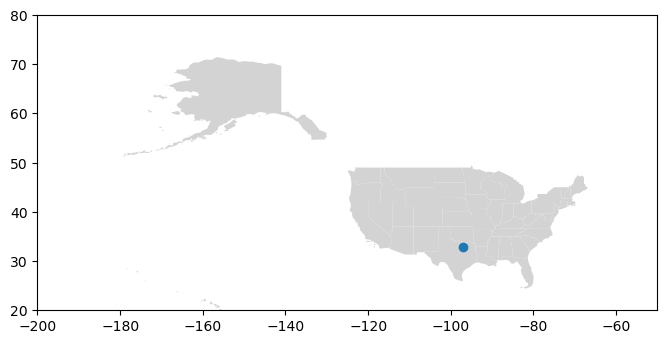

In [70]:
us_nation_map = gpd.read_file('/Users/johannahoang/PycharmProjects/NationalDocData/tl_2022_us_state.shx') #my code called for shx

us_nation_map.crs = 'EPSG:4326' #code was finicky about setting crs first
crs = us_nation_map.crs #wanted this defined when setting parameters for geo_df
fig, ax = plt.subplots(figsize=(8, 8))
us_nation_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')

ax.set_xlim(-200, -50)
ax.set_ylim(20, 80)

geometry = [Point(float(lat), float(lon))]
geo_df = gpd.GeoDataFrame(pd.DataFrame(), crs=crs, geometry=geometry)
geo_df.plot(ax=ax)

# Create interactive map 
- folium
- gpd explore

In [73]:
gdf = gpd.GeoDataFrame(test_df, crs=crs, geometry=geometry)

In [74]:
gdf = gdf[['Primary', 'Address', 'geometry']].fillna(0) #pulls data values to show when hovering over point

In [75]:
print(gdf)

              Primary          Address                    geometry
0  NURSE PRACTITIONER  1582 N BROAD ST  POINT (-96.96143 32.86541)


In [76]:
gdf.explore()

# Creating loop
- extracting data from addresses dataframe into the API to find the lat and lon 
- putting data into dictionary
- extracting values from dictionary to dataframe

In [26]:
#drop primary specitalty
geoaddress = addresses.drop('pri_spec', axis=1)

In [27]:
#get range
x=0
x=x+1
addressbatch = geoaddress.iloc[1:2]
addressbatch

,adr_ln_1,cty,st,zip
1,5632 ANNAPOLIS RD,BLADENSBURG,MD,207102213


In [28]:
#make row index
addressbatch.columns = addressbatch.iloc[0]
addressbatch = addressbatch[1:]

In [29]:
addressbatch

1,5632 ANNAPOLIS RD,BLADENSBURG,MD,207102213


In [30]:
#build csv
output_file = 'addresses.csv'
output_dir = Path('Users/johannahoang/PycharmProjects/NationalDocData')
output_dir.mkdir(parents=True, exist_ok=True)
addressbatch.to_csv(output_dir / output_file)  # can join path elements with / operator

In [31]:
#read one line of csv
URL = 'https://geocoding.geo.census.gov/geocoder/locations/addressbatch'
with open('/Users/johannahoang/PycharmProjects/NationalDocData/Users/johannahoang/PycharmProjects/NationalDocData/addresses.csv', 'rb') as input_file:
    geo = requests.post(files={'addressFile': input_file}, url=URL, data={'benchmark':'Public_AR_Current'})

#data = need to change response to text and separate values

gdf = pd.read_csv(io.StringIO(geo.text), sep=',', header=None, quoting=csv.QUOTE_ALL, index_col= False)
gdf.reset_index()

# Looping all the values now

In [57]:
batch = 10
geo_dict=[]

#to keep the same number of indexes even for data that don't match (only would return 3 versus the 8)

for x in range(batch):
    y=x+1
    addressbatch = geoaddress.iloc[x:y]
    addressbatch.columns = addressbatch.iloc[0]
    addressbatch = addressbatch[1:]
    #build csv
    output_file = 'addresses.csv'
    output_dir = Path('Users/johannahoang/PycharmProjects/NationalDocData')
    output_dir.mkdir(parents=True, exist_ok=True)
    addressbatch.to_csv(output_dir / output_file) 
    
    #read one line of csv
    URL = 'https://geocoding.geo.census.gov/geocoder/locations/addressbatch'
    with open('/Users/johannahoang/PycharmProjects/NationalDocData/Users/johannahoang/PycharmProjects/NationalDocData/addresses.csv', 'rb') as input_file:
        geo = requests.post(files={'addressFile': input_file}, url=URL, data={'benchmark':'Public_AR_Current'})
    gdf = pd.read_csv(io.StringIO(geo.text), sep=',', header=None, quoting=csv.QUOTE_ALL, index_col= False)
    gdf.reset_index()
    #get coordinates
    coord = gdf.iloc[0][5]
    primary= addresses['pri_spec'].iloc[x]
    lat, lon = coord.split(',')
    
    #establishing dictionary to append to geo_dict
    new_dict = {}
    new_dict['Latitude'] = lat
    new_dict['Longitude'] = lon
    new_dict['Primary'] = primary
    new_dict['Address'] = addresses['adr_ln_1'].iloc[x]
    #new_dict['Geometry'] = Point(float(lat), float(lon))
    geo_dict.append(new_dict)
    x=x+1

    
geo_df = pd.DataFrame(geo_dict)
print(geo_df)


              Latitude           Longitude                 Primary  \
0   -83.56973712399997   36.45086948900007      NURSE PRACTITIONER   
1   -76.92014292199997   38.93927167000004      NURSE PRACTITIONER   
2  -104.81961909699999  41.171238189000064       INTERNAL MEDICINE   
3   -75.73508861399995   40.86876549600004            CHIROPRACTIC   
4  -118.57960257299999  34.168001512000046  CLINICAL SOCIAL WORKER   
5   -73.62646380899997   41.02953406100005               OPTOMETRY   
6   -98.38457212999998   40.92259203400005          ANESTHESIOLOGY   
7  -115.26197265499997  36.218289311000035         FAMILY PRACTICE   
8   -98.53511370899997  29.514970250000033               NEUROLOGY   
9   -96.96143273199999   32.86541246000007               NEUROLOGY   

                 Address  
0        1582 N BROAD ST  
1      5632 ANNAPOLIS RD  
2       611 E CARLSON ST  
3            30 RIVER ST  
4     20501 VENTURA BLVD  
5       87 GREENWICH AVE  
6        826 N DIERS AVE  
7    7660 W C

In [54]:
#print(type(gdf['Geometry'].iloc[1]))


<class 'shapely.geometry.point.Point'>


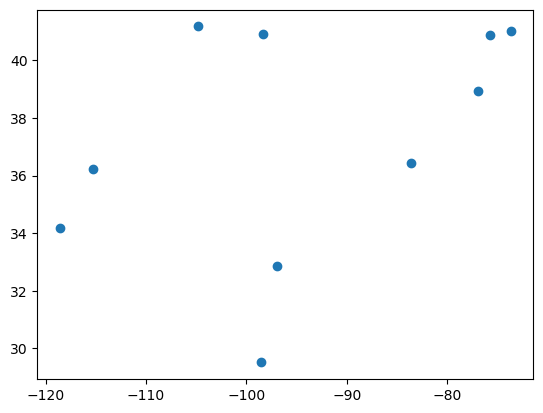

In [44]:
point_list = geo_df['Geometry'].tolist()

# points = [Point(-4.85624511894443, 37.1837967179202), 
#           Point(-4.855703975302475, 37.18401757756585),
#           Point(-4.85516283166052, 37.1842384372115),
#           Point(-4.85343407576431, 37.182006629169),
#           Point(-4.85347524651836, 37.1804461589773),
#           Point(-4.855792124429867, 37.18108913443582),
#           Point(-4.85624511894443, 37.1837967179202)]
xs = [point.x for point in point_list]
ys = [point.y for point in point_list]
plt.scatter(xs, ys)
# or plt.plot(xs, ys) if you want to connect points by lines

In [58]:
#convert long and lat to points with geodataframe
geo_df = gpd.GeoDataFrame(geo_df, geometry = gpd.points_from_xy(geo_df.Longitude, geo_df.Latitude))

In [59]:
print(geo_df)

              Latitude           Longitude                 Primary  \
0   -83.56973712399997   36.45086948900007      NURSE PRACTITIONER   
1   -76.92014292199997   38.93927167000004      NURSE PRACTITIONER   
2  -104.81961909699999  41.171238189000064       INTERNAL MEDICINE   
3   -75.73508861399995   40.86876549600004            CHIROPRACTIC   
4  -118.57960257299999  34.168001512000046  CLINICAL SOCIAL WORKER   
5   -73.62646380899997   41.02953406100005               OPTOMETRY   
6   -98.38457212999998   40.92259203400005          ANESTHESIOLOGY   
7  -115.26197265499997  36.218289311000035         FAMILY PRACTICE   
8   -98.53511370899997  29.514970250000033               NEUROLOGY   
9   -96.96143273199999   32.86541246000007               NEUROLOGY   

                 Address                 geometry  
0        1582 N BROAD ST   POINT (36.451 -83.570)  
1      5632 ANNAPOLIS RD   POINT (38.939 -76.920)  
2       611 E CARLSON ST  POINT (41.171 -104.820)  
3            30 RIVER

In [60]:
geo_df.explore()

# Try different batch method
- from:AswanMorder https://github.com/AswanMordor/NationalDocDatasetProject/blob/main/SpecalitiesByLocation.ipynb

In [79]:
test_batch_size = 10
# 'adr_ln_1', 'cty', 'st', 'zip'
csv_headers = ['adr_ln_1', 'cty', 'st', 'zip']
addresses[:5000].to_csv('batched_addresses.csv', columns=csv_headers, header=None)

URL = 'https://geocoding.geo.census.gov/geocoder/locations/addressbatch'
with open('batched_addresses.csv', 'rb') as input_file:
    geo = requests.post(files={'addressFile': input_file}, url=URL, data={'benchmark':'Public_AR_Current'})
    
names = [
    'id',
    'given_address',
    'match',
    'match_level',
    'official_address',
    'long_lat',
    'tertiary_coord',
    'letter'
]
 # from: https://github.com/msjopyho/NationalDocDatasetProject/blob/main/NationalDocDatasetProject.ipynb
gdf = pd.read_csv(io.StringIO(geo.text.strip('\n')), sep=',', header=None, quoting=csv.QUOTE_ALL, index_col= False, names=names)



In [80]:
#clean data (remove NaN values)
gdf.reset_index()
#get coordinates
print(type(gdf.iloc[0][5]))

<class 'float'>


In [81]:
#clean data (remove NaN values)
clean_gdf = gdf.dropna(subset = ['letter'])
print(clean_gdf.shape)

(3918, 8)


In [83]:
clean_gdf[['Longitude', 'Latitude']] = (
    clean_gdf['long_lat'].astype(str).str.split(',', expand=True).astype(float)
)
print(clean_gdf)

        id                                      given_address  match  \
1     3640         277 ALEXANDER ST, ROCHESTER, NY, 146071920  Match   
2     4971            430 W BROADWAY, NEW YORK, NY, 100123784  Match   
4     3638    3371 US HWY 1 154, LAWRENCEVILLE, NJ, 086481307  Match   
6     2305  4649 CLYDE MORRIS BLVD, PORT ORANGE, FL, 32129...  Match   
7     3639               916 E 24 ST, BROOKLYN, NY, 112103612  Match   
...    ...                                                ...    ...   
4993  4954        115 GALLERY CIR, SAN ANTONIO, TX, 782583389  Match   
4995  4955     13642 W HILLSBOROUGH AVE, TAMPA, FL, 336359638  Match   
4996  3628            39 MEADOW RD, RUTHERFORD, NJ, 070702009  Match   
4997  4956          2756 S BROADWAY AVE, TYLER, TX, 757015412  Match   
4999  4957              1221 PEARL ST, BOULDER, CO, 803025204  Match   

     match_level                                  official_address  \
1          Exact            277 ALEXANDER ST, ROCHESTER, NY, 1460

In [84]:
#convert long and lat to points with geodataframe (just typing it out as Point 'blank' doesn't work well in .explore())
clean_gdf = gpd.GeoDataFrame(clean_gdf, crs=crs, geometry = gpd.points_from_xy(clean_gdf.Longitude, clean_gdf.Latitude))

In [85]:
clean_gdf.explore()